In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, classification_report
import time
import pickle
import os

In [2]:
def one_hot(y, num_classes=10):
    y = np.array(y, dtype=int)
    return np.eye(num_classes)[y]

def softmax(z):
    # z: (batch, classes)
    z_stable = z - np.max(z, axis=1, keepdims=True)
    exp = np.exp(z_stable)
    return exp / np.sum(exp, axis=1, keepdims=True)

def relu(z):
    return np.maximum(0, z)

def drelu(z):
    return (z > 0).astype(float)

def cross_entropy_loss(probs, y_true_onehot):
    # probs: (batch, classes), y_true_onehot: (batch, classes)
    m = probs.shape[0]
    # add epsilon for numeric stability
    eps = 1e-12
    log_likelihood = -np.log(np.sum(probs * y_true_onehot, axis=1) + eps)
    loss = np.mean(log_likelihood)
    return loss

def accuracy_from_probs(probs, y_true):
    preds = np.argmax(probs, axis=1)
    return np.mean(preds == y_true)

In [3]:
def init_params(layer_dims, seed=None):
    if seed is not None:
        np.random.seed(seed)
    params = {}
    L = len(layer_dims) - 1
    for l in range(1, L + 1):
        input_dim = layer_dims[l-1]
        output_dim = layer_dims[l]
        # He init for ReLU
        params[f"W{l}"] = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / max(1, input_dim))
        params[f"b{l}"] = np.zeros((1, output_dim))
    return params

In [4]:
def forward(X, params):
    """
    X: (batch, input_dim)
    params: dict
    Returns: caches (list of dicts per layer), output probs
    """
    caches = []
    A = X
    L = len([k for k in params.keys() if k.startswith("W")])
    for l in range(1, L):
        W = params[f"W{l}"]
        b = params[f"b{l}"]
        Z = A @ W + b  # (batch, units)
        A = relu(Z)
        caches.append({"Z": Z, "A_prev": None, "W": W, "b": b, "A": A})
    # Output layer (no ReLU) -> linear then softmax
    W_out = params[f"W{L}"]
    b_out = params[f"b{L}"]
    Z_out = A @ W_out + b_out
    probs = softmax(Z_out)
    caches.append({"Z": Z_out, "A_prev": None, "W": W_out, "b": b_out, "A": probs})
    return caches, probs

In [5]:
def backward(X_batch, y_batch_onehot, params, caches):
    """
    Compute gradients for all params.
    X_batch: (batch, input_dim)
    y_batch_onehot: (batch, classes)
    caches: produced by forward()
    returns grads dict
    """
    grads = {}
    m = X_batch.shape[0]
    L = len(caches)  # number of layers (including output)
    # Start with output layer gradient
    probs = caches[-1]["A"]  # (m, C)
    dZ = (probs - y_batch_onehot) / m  # derivative of cross-entropy with softmax
    # We'll iterate backwards
    for l_idx in range(L - 1, -1, -1):
        layer_num = l_idx + 1
        W = params[f"W{layer_num}"]
        # find activation before this layer:
        if l_idx == 0:
            A_prev = None  # it's previous layer or input; we'll handle separately
        else:
            A_prev = caches[l_idx - 1]["A"]
        # If this is first hidden layer, A_prev is X_batch
        if A_prev is None:
            if layer_num == 1:
                A_prev_for_grad = X_batch
            else:
                A_prev_for_grad = X_batch  # fallback, shouldn't happen
        else:
            A_prev_for_grad = A_prev
        # gradients
        dW = A_prev_for_grad.T @ dZ  # (units_prev, units_curr)
        db = np.sum(dZ, axis=0, keepdims=True)
        grads[f"dW{layer_num}"] = dW
        grads[f"db{layer_num}"] = db
        # compute dA_prev for next iteration (backprop)
        if layer_num > 1:
            dA_prev = dZ @ W.T  # (m, units_prev)
            # multiply by derivative of relu at previous layer's Z
            Z_prev = caches[layer_num - 2]["Z"]  # because caches indexed 0..L-1
            dZ = dA_prev * drelu(Z_prev)
    return grads

In [6]:
def update_params(params, grads, lr):
    L = len([k for k in params.keys() if k.startswith("W")])
    for l in range(1, L + 1):
        params[f"W{l}"] -= lr * grads[f"dW{l}"]
        params[f"b{l}"] -= lr * grads[f"db{l}"]
    return params

In [7]:
def create_mini_batches(X, y_onehot, batch_size, seed=None):
    m = X.shape[0]
    indices = np.arange(m)
    if seed is not None:
        np.random.seed(seed)
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    y_shuffled = y_onehot[indices]
    mini_batches = []
    for start in range(0, m, batch_size):
        end = min(start + batch_size, m)
        mini_batches.append((X_shuffled[start:end], y_shuffled[start:end]))
    return mini_batches

In [8]:
def train(X_train, y_train_onehot, X_val, y_val, layer_dims,
          epochs=30, batch_size=64, lr=0.01, seed=42, print_every=1):
    params = init_params(layer_dims, seed=seed)
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    for epoch in range(1, epochs + 1):
        t0 = time.time()
        mini_batches = create_mini_batches(X_train, y_train_onehot, batch_size, seed=seed + epoch)
        epoch_losses = []
        for X_batch, y_batch in mini_batches:
            caches, probs = forward(X_batch, params)
            loss = cross_entropy_loss(probs, y_batch)
            epoch_losses.append(loss)
            grads = backward(X_batch, y_batch, params, caches)
            params = update_params(params, grads, lr)
        # End epoch: compute validation metrics
        _, val_probs = forward(X_val, params)
        val_loss = cross_entropy_loss(val_probs, one_hot(y_val, layer_dims[-1]))
        val_acc = accuracy_from_probs(val_probs, y_val)
        avg_train_loss = np.mean(epoch_losses)
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        if epoch % print_every == 0:
            t1 = time.time()
            print(f"Epoch {epoch}/{epochs} - time: {t1-t0:.2f}s - train_loss: {avg_train_loss:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")
    return params, history

In [9]:
def predict(X, params):
    _, probs = forward(X, params)
    preds = np.argmax(probs, axis=1)
    return preds, probs

In [10]:
input_dim = 784
hidden1 = 128
hidden2 = 64
output_dim = 10
layer_dims = [input_dim, hidden1, hidden2, output_dim]
epochs = 30
batch_size = 64
lr = 0.01
seed = 1

Loading MNIST dataset

In [ ]:
mnist = fetch_openml('mnist_784', version=1)  # uses sklearn's fetch_openml
X = mnist.data.astype(np.float32)
y = mnist.target.astype(int)
print("Raw data shape:", X.shape, y.shape)

Loading MNIST dataset (this may take a moment)...
Raw data shape: (70000, 784) (70000,)


In [12]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_scaled, y, test_size=10000, random_state=seed, stratify=y)
# From the remaining ~60k, reserve 10% for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.10, random_state=seed, stratify=y_train_full)
print("Train/Val/Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

Train/Val/Test sizes: 54000 6000 10000


In [14]:
y_train_onehot = one_hot(y_train, num_classes=output_dim)

Training

In [ ]:
params, history = train(X_train, y_train_onehot, X_val, y_val, layer_dims,
epochs=epochs, batch_size=batch_size, lr=lr, seed=seed, print_every=1)


Starting training...
Epoch 1/30 - time: 1.65s - train_loss: 0.8300 - val_loss: 0.4331 - val_acc: 0.8787
Epoch 2/30 - time: 1.50s - train_loss: 0.3571 - val_loss: 0.3456 - val_acc: 0.9028
Epoch 3/30 - time: 1.32s - train_loss: 0.2964 - val_loss: 0.3104 - val_acc: 0.9148
Epoch 4/30 - time: 1.16s - train_loss: 0.2640 - val_loss: 0.2832 - val_acc: 0.9220
Epoch 5/30 - time: 1.29s - train_loss: 0.2409 - val_loss: 0.2617 - val_acc: 0.9287
Epoch 6/30 - time: 1.25s - train_loss: 0.2224 - val_loss: 0.2463 - val_acc: 0.9328
Epoch 7/30 - time: 1.30s - train_loss: 0.2070 - val_loss: 0.2324 - val_acc: 0.9342
Epoch 8/30 - time: 1.31s - train_loss: 0.1938 - val_loss: 0.2190 - val_acc: 0.9395
Epoch 9/30 - time: 1.21s - train_loss: 0.1820 - val_loss: 0.2090 - val_acc: 0.9437
Epoch 10/30 - time: 1.24s - train_loss: 0.1714 - val_loss: 0.2028 - val_acc: 0.9435
Epoch 11/30 - time: 1.41s - train_loss: 0.1622 - val_loss: 0.1933 - val_acc: 0.9443
Epoch 12/30 - time: 1.34s - train_loss: 0.1537 - val_loss: 0.184

Evaluation

In [ ]:

y_pred_test, probs_test = predict(X_test, params)
acc_test = accuracy_score(y_test, y_pred_test)
prec_test = precision_score(y_test, y_pred_test, average='macro', zero_division=0)
f1_test = f1_score(y_test, y_pred_test, average='macro', zero_division=0)
cm = confusion_matrix(y_test, y_pred_test)

Evaluating on test set...


In [17]:

print("\n--- Test results ---")
print(f"Accuracy: {acc_test:.4f}")
print(f"Precision (macro): {prec_test:.4f}")
print(f"F1 Score (macro): {f1_test:.4f}")
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, digits=4, zero_division=0))


--- Test results ---
Accuracy: 0.9689
Precision (macro): 0.9688
F1 Score (macro): 0.9687

Confusion Matrix:
[[ 968    0    1    1    1    4    5    2    4    0]
 [   0 1107    4    3    1    1    1    3    5    0]
 [   4    3  958    7    4    2    2    8    7    4]
 [   0    1    8  977    1    8    4    6    9    6]
 [   1    2    3    1  947    0    3    2    2   14]
 [   1    3    1   12    1  868    4    0    5    7]
 [   5    3    3    0    3    5  958    1    4    0]
 [   1    4    7    5    1    1    0 1015    2    6]
 [   3    7    1    7    2    4    3    0  941    7]
 [   4    3    1   10   13    1    0    7    5  950]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9807    0.9817    0.9812       986
           1     0.9771    0.9840    0.9805      1125
           2     0.9706    0.9590    0.9648       999
           3     0.9550    0.9578    0.9564      1020
           4     0.9723    0.9713    0.9718       975
           

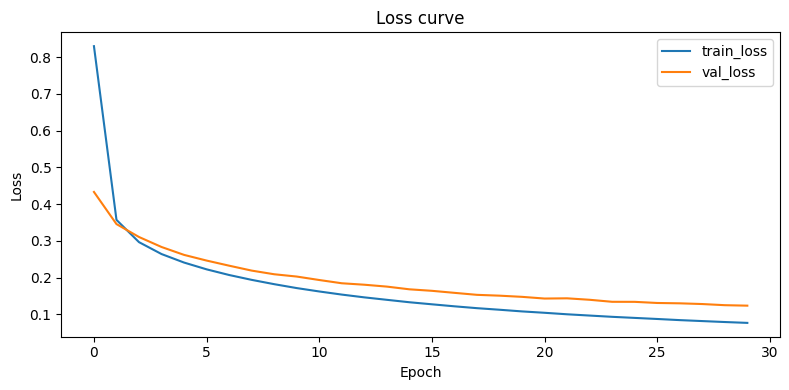

In [18]:
plt.figure(figsize=(8,4))
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curve")
plt.tight_layout()